Timer para medir cuanto tiempo tarda cada parte del proceso

In [1]:
from timer import Timer
timer = Timer()

Definiciones de nombres de archivos de entrada y salida

In [2]:
T_FILE = "../data/tiempos.bin"
O_FILE = "../data/sic_phi.bin"

Lectura de datos

In [3]:
from read_times import read_times

In [4]:
timer.start()
t1, t2, t3, t4 = read_times(T_FILE)
timer.end("Finished reading data ({:.3f}s)")

Finished reading data (0.500s)


Now, we can estimate the $\Phi$ values using that $\Phi = (t_1-t_2-t_3+t_4)/2$

In [5]:
from estimate_phi import phi_estimation

timer.start()
phi_est = phi_estimation(t1, t2, t3, t4)
timer.end("Finished Phi estimation ({:.3f}s)")

Finished Phi estimation (0.016s)


And plot the results

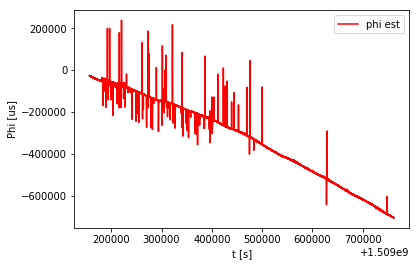

In [6]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(t1/1e6,phi_est,c='r')
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('phi est',''));

Para completar los segundos que se saltea y los cambios no sean tan bruscos, interpolamos:

In [7]:
from estimate_phi import interpolate_missing_values

t1, phi_est = interpolate_missing_values(t1, phi_est)

In order to avoid the peaks in the figure, we can smooth the data replacing each point with the median of a window of 600 points

In [8]:
from median_calculator import median_window
import numpy as np

T1_OUT_FILE = "../data/t1.bin"

timer.start()
phi_med_600 = median_window(phi_est, 600)
phi_med_600 = np.array(phi_med_600)
t1 = t1[:len(phi_med_600)]
timer.end("Finished Phi median 600 ({:.3f}s)")

Finished Phi median 600 (9.278s)


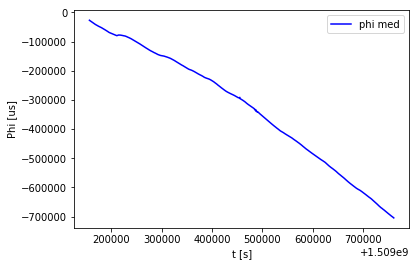

In [9]:
plt.plot(t1/1e6,phi_med_600,c='b')
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('phi med',''));

And now we smooth again the data by using a linear regression

In [10]:
phi_med_600 = phi_med_600[:len(phi_med_600)//60*60]
t1 = t1[:len(phi_med_600)]
t1.tofile(T1_OUT_FILE)

In [11]:
from estimate_phi import linear_reg
timer.start()
f_lin, k_lin = linear_reg(t1, phi_med_600, 60)
phi_lin = np.zeros(len(t1))

for i in range(len(t1) // 60):
    phi_lin[i * 60:(i + 1) * 60] = t1[i * 60:(i + 1) * 60] * f_lin[i] + k_lin[i]
timer.end("Finished Phi lin reg 60 ({:.3f}s)")

Finished Phi lin reg 60 (5.351s)


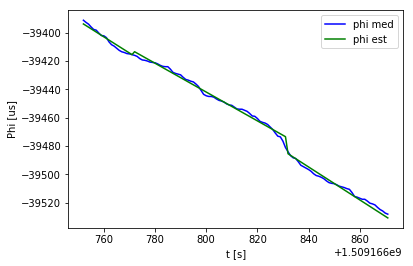

In [12]:
start = 10000
end = start + 120
plt.plot(t1[start:end]/1e6,phi_med_600[start:end],c='b');
plt.plot(t1[start:end]/1e6,phi_lin[start:end],c='g')
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('phi med', 'phi est'));

Now we apply an ARMA filter

In [13]:
from estimate_phi import arma_filter

timer.start()
alpha = 0.15
f, k = arma_filter(f_lin, k_lin, alpha)
phi_arma = np.zeros(len(t1))
for i in range(len(t1) // 60):
    phi_arma[i * 60:(i + 1) * 60] = t1[i * 60:(i + 1) * 60] * f[i] + k[i]
timer.end("Finished Phi ARMA ({:.3f}s)")

Finished Phi ARMA (0.147s)


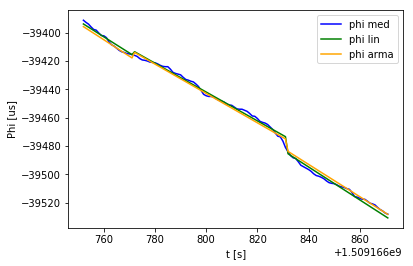

In [14]:
start = 10000
end = start + 120
plt.plot(t1[start:end]/1e6,phi_med_600[start:end],c='b')
plt.plot(t1[start:end]/1e6,phi_lin[start:end],c='g')
plt.plot(t1[start:end]/1e6,phi_arma[start:end],c='orange')
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('phi med','phi lin', 'phi arma'));

In [15]:
phi_arma.tofile(O_FILE)